<a href="https://colab.research.google.com/github/learnsomething2/DSR_DS_Fundamental/blob/main/DSR_Spoken_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sound Computing with neuronal networks


In [20]:
!pip install pydub tensorflow_io

In [21]:
import tensorflow_datasets as tfds

(dataset_train_original, dataset_validate_original), info = tfds.load( 
    "spoken_digit",
    split=["train[:80%]", "train[80%:]"],
    with_info = True
)
info

tfds.core.DatasetInfo(
    name='spoken_digit',
    version=1.0.9,
    description='A free audio dataset of spoken digits. Think MNIST for audio.

A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz.
The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

5 speakers
2,500 recordings (50 of each digit per speaker)
English pronunciations

Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav',
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=2500,
    splits={
        'train': 2500,
    },
    supervised_keys=('audio', 'label'),
    citation="""@ONLINE {Free Spoken Digit Dataset,
        author = "Zohar Jackson",
        

Look at your f****ing data.


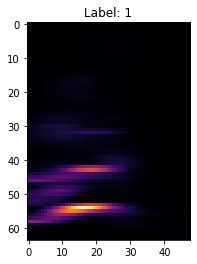

In [30]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import numpy as np
import librosa

for sample in dataset_train_original.shuffle(2500).take(1):
    audio = sample["audio"].numpy().astype("float32")
    label = sample["label"].numpy()

#   plt.plot(audio)
#   plt.show()
#   plt.close()

# mel spectrogram
    mel = librosa.feature.melspectrogram(
       y=audio, sr=8000, n_mels=64, hop_length=64, fmax=2000
    )
    mel /= np.max(mel)
#   print(mel.shape)
    plt.imshow(mel[::-1, :], cmap="inferno")
    plt.title(f"Label: {label}")
 #  display(Audio(audio, rate=8000))

   #print(audio)
   #print(label)

In [23]:
1525 / 8000

0.190625

(64, 64, 1)


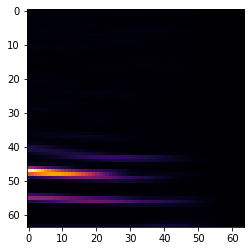

In [24]:
import tensorflow as tf
import tensorflow_io as tfio

def preprocess(sample):
  audio = sample["audio"]
  label = sample["label"]
   
  audio = tf.cast(audio, tf.float32) / 32768.0

  spectrogram = tfio.audio.spectrogram(
      audio, nfft=1024, window=1024, stride=64
  )
  spectrogram = tfio.audio.melscale(
      spectrogram, rate=8000, mels=64, fmin=0, fmax=2000
  )
  spectrogram /= tf.math.reduce_max(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=-1)
  spectrogram = tf.image.resize(spectrogram, (64,64))
  spectrogram = tf.transpose(spectrogram, perm=(1, 0, 2))
  spectrogram = spectrogram[::-1, :, :]

  return spectrogram, label

dataset = dataset_train_original.map(lambda sample: preprocess(sample))

for x, y in dataset.take(1):
  x = x.numpy()
  print(x.shape)
  plt.imshow(x.squeeze(), cmap="inferno")


In [25]:
dataset_train = dataset_train_original.map(lambda sample: preprocess(sample))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(32)

dataset_validate = dataset_validate_original.map(lambda sample: preprocess(sample))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(32)



In [26]:
epochs = 50

from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(8, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(8, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate

)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 64, 64, 4)         40        
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 8)         584       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 8, 8, 8)         